# Training XGBoost Models on All Three Datasets

In [1]:
import torch
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import pandas as pd

# Define data source (data was downloaded from Kaggle and uploaded to our Github Repo)
diabetes_012_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_binary_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_binary_health_indicators_BRFSS2015.csv'
diabetes_binary_5050split_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'

# Load the CSV file
diabetes_012_health_indicators_BRFSS2015 = pd.read_csv(diabetes_012_health_indicators_BRFSS2015)
diabetes_binary_health_indicators_BRFSS2015 = pd.read_csv(diabetes_binary_health_indicators_BRFSS2015)
diabetes_binary_5050split_health_indicators_BRFSS2015 = pd.read_csv(diabetes_binary_5050split_health_indicators_BRFSS2015)

In [3]:
# Check if current device's cuda compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Current device is: {device}')

Current device is: cuda


In [4]:
def confusion_plot(labels, preds, name='', classes=[0, 1, 2]):
    '''
    Visualize the confusion matrix data based on given labels and predictions
    
        Args:
            labels: Groundtruth labels
                (array-like)
            preds: Predicted values
                (array-like)
            name: A title for the confusion matrix plot. Defaults to an empty string.
                (str)
            classes: A list of class names corresponding to the classes in the confusion matrix.  Defaults to [0, 1, 2].
                (list)
    '''

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    print(f'{name} accuracy: {accuracy * 100:.2f}%')

    # Compute the confusion matrix
    cf = confusion_matrix(labels, preds, labels=classes, normalize='true')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt=".2f")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [5]:
def paramGridSearchCV(model, param_grid, X_train, y_train, num_cv=3, verbose=3):
    '''
    Perform a grid search to find the best combination of parameters for the provided model.
    
        Args:
            model: A model (e.g., from scikit-learn) to be tuned.
                (estimator)
            param_grid: A dictionary specifying the parameters and the range of values to search.
                (dict)
            X_train: A feature matrix.
                (np.array)
            y_train: A vector that records the response variable.
                (np.array)
            num_cv: The number of cross-validation folds. Defaults to 3.
                (int)
            verbose: The level of verbosity for the GridSearchCV process.
                (int)
        
        Returns:
            best_params: A dictionary containing the best parameters found during the grid search.
                (np.array)
    '''
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=num_cv, verbose=verbose)
    grid_search.fit(X_train, y_train)

    # Best parameters
    best_params = grid_search.best_params_
    print(best_params)

    return best_params

### 1. XGBoost on 5050-split Binary

In [6]:
# 5050-split binary dataset
# `diabetes_binary_5050split_health_indicators_BRFSS2015`
X_diabetes01_5050 = diabetes_binary_5050split_health_indicators_BRFSS2015.drop(['Diabetes_binary'], axis=1)
y_diabetes01_5050 = diabetes_binary_5050split_health_indicators_BRFSS2015.Diabetes_binary

X_train_diabetes01_5050, X_test_diabetes01_5050, y_train_diabetes01_5050, y_test_diabetes01_5050 = train_test_split(
    X_diabetes01_5050, y_diabetes01_5050, test_size=0.2, stratify=y_diabetes01_5050, random_state=11
)

In [7]:
# Define the parameter grid
param_grid_diabetes01_5050 = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 300, 500],
    'min_child_weight': [1, 3, 5],
    'device': [device],
    'verbosity': [0],
    'objective': ['binary:logistic']
}

model = xgb.XGBClassifier()

best_params_diabetes01_5050 = paramGridSearchCV(
    model, param_grid_diabetes01_5050, X_train_diabetes01_5050, y_train_diabetes01_5050
)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, objective=binary:logistic, verbosity=0;, score=0.729 total time=   0.4s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, objective=binary:logistic, verbosity=0;, score=0.733 total time=   0.1s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, objective=binary:logistic, verbosity=0;, score=0.735 total time=   0.1s
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, objective=binary:logistic, verbosity=0;, score=0.740 total time=   0.2s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, objective=binary:logistic, verbosity=0;, score=0.743 total time=   0.2s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, objective=binary:logistic, verbosity=0;, score=0.747 tot

In [8]:
# Use best params from GridSearchCV
dtrain_diabetes01_5050 = xgb.DMatrix(X_train_diabetes01_5050, label=y_train_diabetes01_5050)

model_diabetes01_5050 = xgb.train(
    params=best_params_diabetes01_5050,
    dtrain=dtrain_diabetes01_5050
)

In [9]:
# Make Predictions on the validation set
dtest_diabetes01_5050 = xgb.DMatrix(X_test_diabetes01_5050, label=y_test_diabetes01_5050)
preds_diabetes01_5050 = (model_diabetes01_5050.predict(dtest_diabetes01_5050) >= 0.5).astype(int)

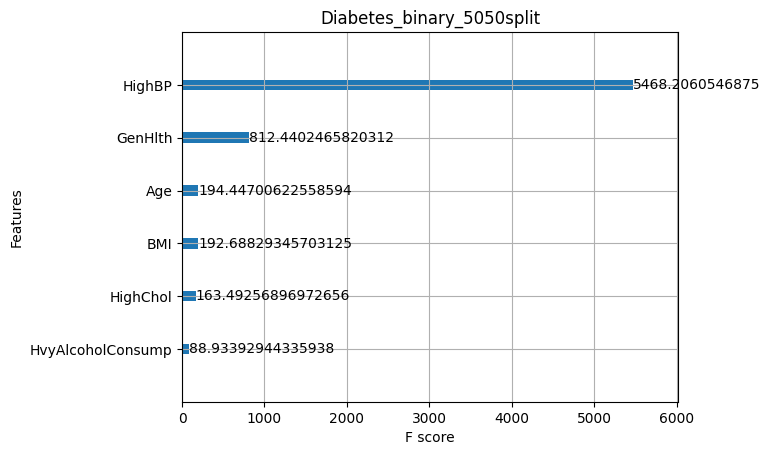

In [10]:
# Plot the top features by importance
xgb.plot_importance(model_diabetes01_5050, importance_type='gain', title='Diabetes_binary_5050split')
plt.show()

Train accuracy: 73.77%


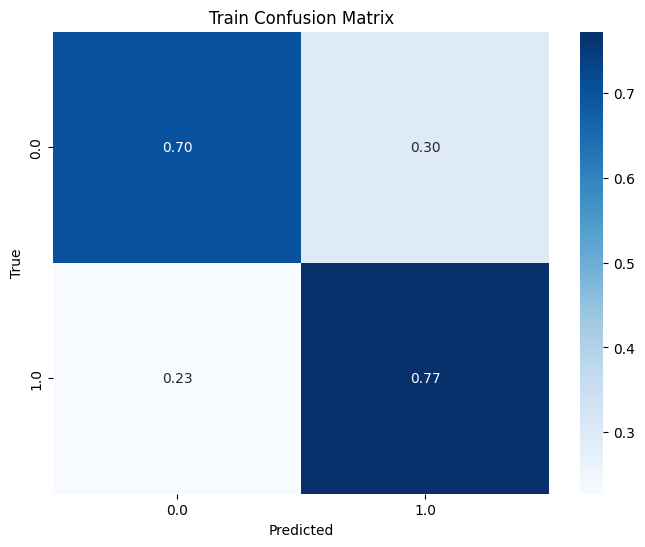

In [11]:
# Plot the confusion matrix values for the training set
confusion_plot(
    y_train_diabetes01_5050, 
    (model_diabetes01_5050.predict(dtrain_diabetes01_5050) >= 0.5).astype(int),
    'Train',
    list(set(y_train_diabetes01_5050)))

Valid accuracy: 74.03%


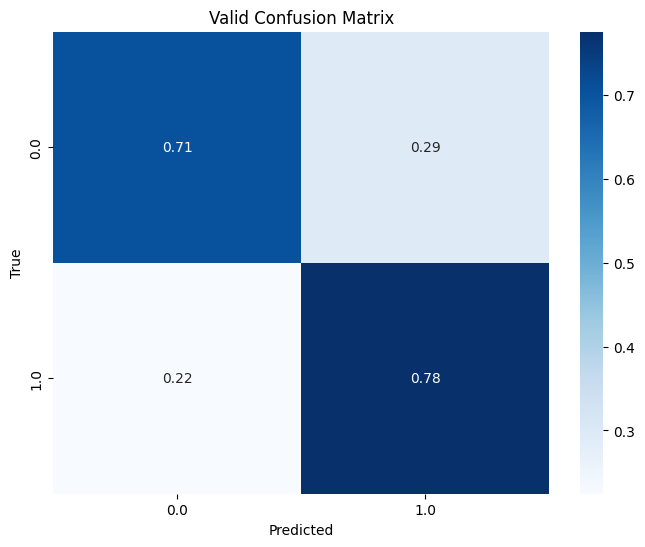

In [12]:
# Plot the confusion matrix values for the validation set
confusion_plot(
    y_test_diabetes01_5050, 
    preds_diabetes01_5050,
    'Valid',
    list(set(y_train_diabetes01_5050)))

### 1. XGBoost on Diabetes_012

In [13]:
# diabetes012 dataset
# `diabetes_012_health_indicators_BRFSS2015`
X_diabetes012 = diabetes_012_health_indicators_BRFSS2015.drop(['Diabetes_012'], axis=1)
y_diabetes012 = diabetes_012_health_indicators_BRFSS2015.Diabetes_012

# Deal with imbalance
df = diabetes_012_health_indicators_BRFSS2015

# Separate the data by class
class_0 = df[df['Diabetes_012'] == 0]
class_1 = df[df['Diabetes_012'] == 1]
class_2 = df[df['Diabetes_012'] == 2]

# Class 2 size
class_2_size = len(class_2)

# Randomly undersample class 0 to match the size of class 2 since class 0 has too many more observations
class_0_undersampled = class_0.sample(n=class_2_size, random_state=11)

# Randomly oversample class 1 to match the size of class 2 since class 1 has too little observations
class_1_oversampled = class_1.sample(n=class_2_size, random_state=11, replace=True)

# Combine the undersampled class 0 data with class 1 and class 2 data
df_sm = pd.concat([class_0_undersampled, class_1_oversampled, class_2])

# Shuffle the combined dataset
df_sm = df_sm.sample(frac=1, random_state=11).reset_index(drop=True)

# Split the features and labels
X_diabetes012_sm = df_sm.drop(['Diabetes_012'], axis=1)
y_diabetes012_sm = df_sm['Diabetes_012']

# Undersampled data split
X_train_diabetes012_sm, X_test_diabetes012_sm, y_train_diabetes012_sm, y_test_diabetes012_sm = train_test_split(
    X_diabetes012_sm, y_diabetes012_sm, test_size=0.2, stratify=y_diabetes012_sm, random_state=11
)

# Original data split
X_train_diabetes012, X_test_diabetes012, y_train_diabetes012, y_test_diabetes012 = train_test_split(
    X_diabetes012, y_diabetes012, test_size=0.2, stratify=y_diabetes012, random_state=11
)

In [14]:
# Define the parameter grid
param_grid_diabetes012 = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 300, 500],
    'min_child_weight': [1, 3, 5],
    'device': [device],
    'verbosity': [0],
    'objective': ['multi:softmax'],
    'num_class': [3]
}

model = xgb.XGBClassifier()

best_params_diabetes012 = paramGridSearchCV(
    model, param_grid_diabetes012, X_train_diabetes012_sm, y_train_diabetes012_sm
)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, num_class=3, objective=multi:softmax, verbosity=0;, score=0.497 total time=   0.6s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, num_class=3, objective=multi:softmax, verbosity=0;, score=0.502 total time=   0.5s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, num_class=3, objective=multi:softmax, verbosity=0;, score=0.502 total time=   0.5s
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, num_class=3, objective=multi:softmax, verbosity=0;, score=0.512 total time=   1.4s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, num_class=3, objective=multi:softmax, verbosity=0;, score=0.517 total time=   1.4s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, n

In [15]:
# Use best params from GridSearchCV
dtrain_diabetes012 = xgb.DMatrix(X_train_diabetes012_sm, label=y_train_diabetes012_sm)

# Train model using undersampled training dataset
model_diabetes012 = xgb.train(
    params=best_params_diabetes012,
    dtrain=dtrain_diabetes012
)

In [16]:
# Make Predictions on the validation set using the original dataset
dtest_diabetes012 = xgb.DMatrix(X_test_diabetes012, label=y_test_diabetes012)
preds_diabetes012 = model_diabetes012.predict(dtest_diabetes012)

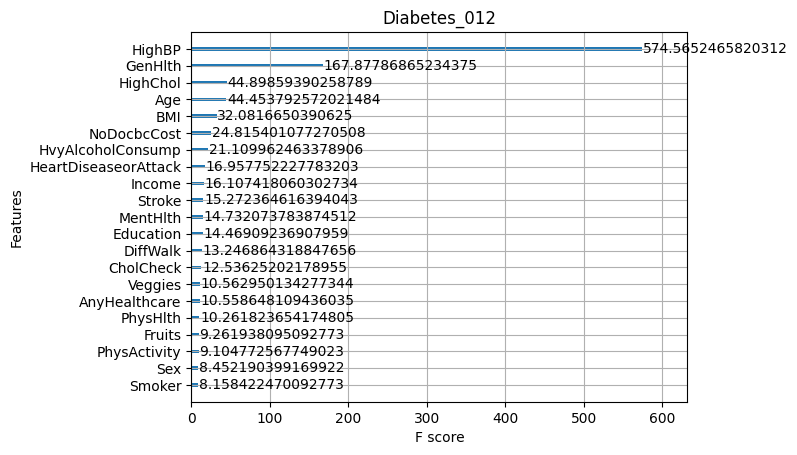

In [17]:
# Plot the top features by importance
xgb.plot_importance(model_diabetes012, importance_type='gain', title='Diabetes_012')
plt.show()

Train accuracy: 54.66%


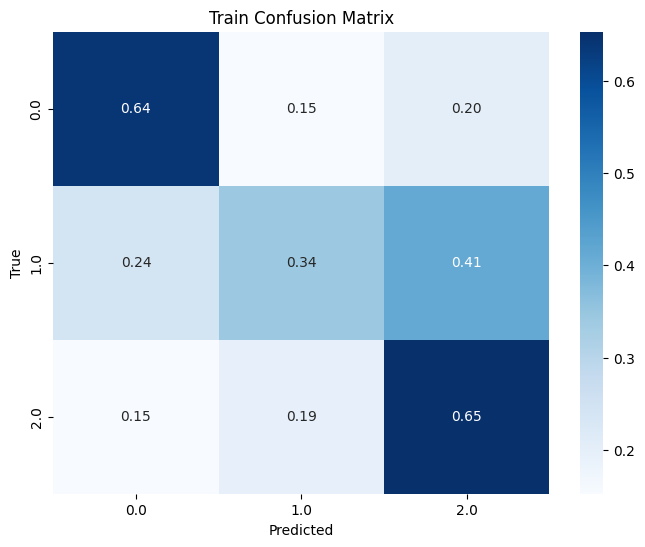

In [18]:
# Plot the confusion matrix values for the undersampled training set
confusion_plot(
    y_train_diabetes012_sm, 
    model_diabetes012.predict(xgb.DMatrix(X_train_diabetes012_sm, label=y_train_diabetes012_sm)),
    'Train',
    list(set(y_train_diabetes012_sm))
)

Valid accuracy: 63.46%


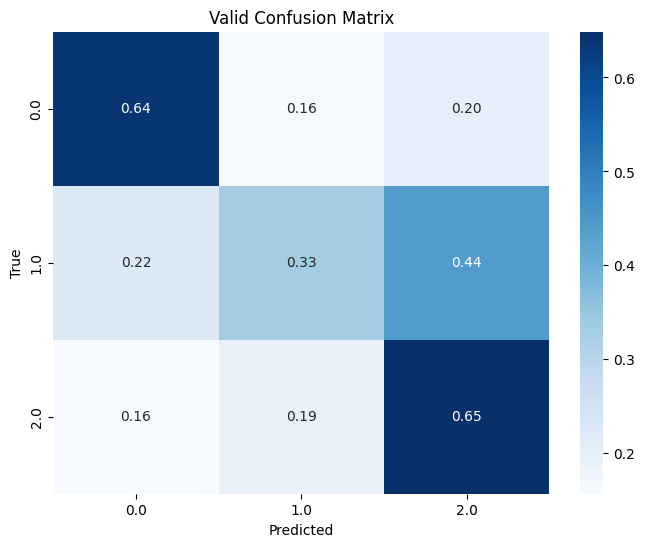

In [19]:
# Plot the confusion matrix values for the original validation set
confusion_plot(
    y_test_diabetes012, 
    preds_diabetes012,
    'Valid',
    list(set(y_test_diabetes012))
)

#### Note

* The performance is not ideal, but let us collapse classes and see how it performs on classifying 0 and $\geq 1$.

In [20]:
preds_diabetes012_collapsed = np.where(preds_diabetes012 == 0, 0, 1)

Collapsed Train accuracy: 74.90%


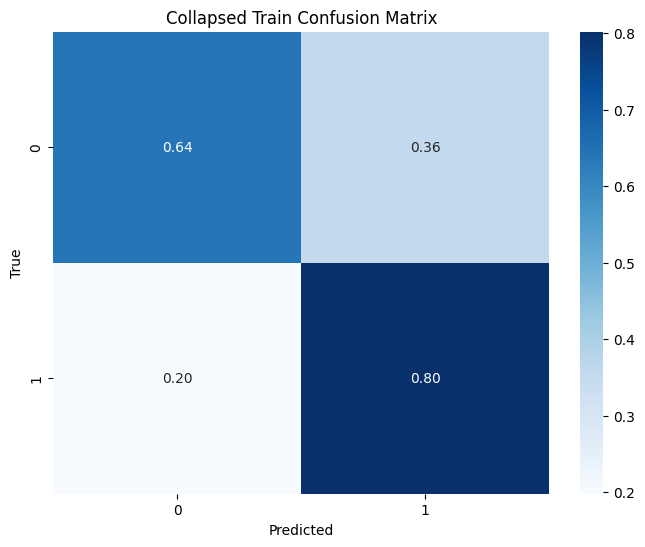

In [21]:
# Plot the confusion matrix values for the undersampled training set
confusion_plot(
    np.where(y_train_diabetes012_sm == 0, 0, 1), 
    np.where(model_diabetes012.predict(xgb.DMatrix(X_train_diabetes012_sm, label=y_train_diabetes012_sm)) == 0, 0, 1),
    'Collapsed Train',
    list(set(np.where(y_train_diabetes012_sm == 0, 0, 1)))
)

Collapsed Valid accuracy: 66.98%


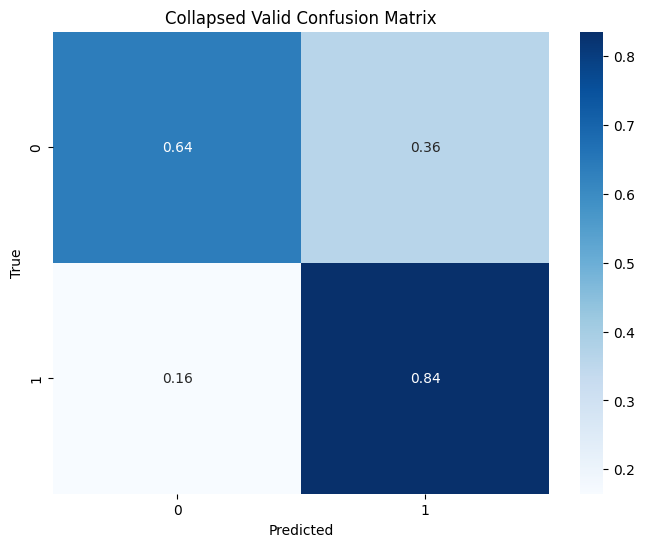

In [ ]:
# Plot the confusion matrix values for the original validation set
confusion_plot(
    np.where(y_test_diabetes012 == 0, 0, 1), 
    preds_diabetes012_collapsed,
    'Collapsed Valid',
    list(set(np.where(y_test_diabetes012 == 0, 0, 1)))
)

#### Insights and Findings

* From the confusion matrix plot, We observe that our model favours the `Sensitivity` metric over the `Specificity` metric. 

* That is, for a patient that is in either pre-diabetes or diabetes condition, our XGBoost model can make a correct prediction with a probability of 84%.

* For a healthy patient, our XGBoost model falsely predict as pre-diabetes or diabetes with a probability of 36%

### 1. XGBoost on Diabetes_binary Imbalance

In [23]:
# diabetes_binary dataset
# `diabetes_binary_health_indicators_BRFSS2015`
X_diabetes01 = diabetes_binary_health_indicators_BRFSS2015.drop(['Diabetes_binary'], axis=1)
y_diabetes01 = diabetes_binary_health_indicators_BRFSS2015.Diabetes_binary

# Deal with imbalance
df = diabetes_binary_health_indicators_BRFSS2015

# Separate the data by class
class_0 = df[df['Diabetes_binary'] == 0]
class_1 = df[df['Diabetes_binary'] == 1]

# Class 1 size
class_1_size = len(class_1)

# Randomly undersample class 0 to match the size of class 1 since class 0 has too many more observations
class_0_undersampled = class_0.sample(n=class_1_size, random_state=11)

# Combine the undersampled class 0 data with class 1 data
df_sm = pd.concat([class_0_undersampled, class_1])

# Shuffle the combined dataset
df_sm = df_sm.sample(frac=1, random_state=11).reset_index(drop=True)

# Split the features and labels
X_diabetes01_sm = df_sm.drop(['Diabetes_binary'], axis=1)
y_diabetes01_sm = df_sm['Diabetes_binary']

X_train_diabetes01_sm, X_test_diabetes01_sm, y_train_diabetes01_sm, y_test_diabetes01_sm = train_test_split(
    X_diabetes01_sm, y_diabetes01_sm, test_size=0.2, stratify=y_diabetes01_sm, random_state=11
)


X_train_diabetes01, X_test_diabetes01, y_train_diabetes01, y_test_diabetes01 = train_test_split(
    X_diabetes01, y_diabetes01, test_size=0.2, stratify=y_diabetes01, random_state=11
)

In [24]:
# Define the parameter grid
param_grid_diabetes01 = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 300, 500],
    'min_child_weight': [1, 3, 5],
    'device': [device],
    'verbosity': [0],
    'objective': ['binary:logistic']
}

model = xgb.XGBClassifier()

best_params_diabetes01 = paramGridSearchCV(
    model, param_grid_diabetes01, X_train_diabetes01_sm, y_train_diabetes01_sm
)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, objective=binary:logistic, verbosity=0;, score=0.739 total time=   0.2s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, objective=binary:logistic, verbosity=0;, score=0.738 total time=   0.2s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, objective=binary:logistic, verbosity=0;, score=0.733 total time=   0.2s
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, objective=binary:logistic, verbosity=0;, score=0.751 total time=   0.4s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, objective=binary:logistic, verbosity=0;, score=0.749 total time=   0.3s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, objective=binary:logistic, verbosity=0;, score=0.743 tot

In [25]:
# Use best params from GridSearchCV using undersampled training set
dtrain_diabetes01 = xgb.DMatrix(X_train_diabetes01_sm, label=y_train_diabetes01_sm)

model_diabetes01 = xgb.train(
    params=best_params_diabetes01,
    dtrain=dtrain_diabetes01
)

In [26]:
# Make Predictions on the original validation set
dtest_diabetes01 = xgb.DMatrix(X_test_diabetes01, label=y_test_diabetes01)
preds_diabetes01 = (model_diabetes01.predict(dtest_diabetes01) >= 0.5).astype(int)

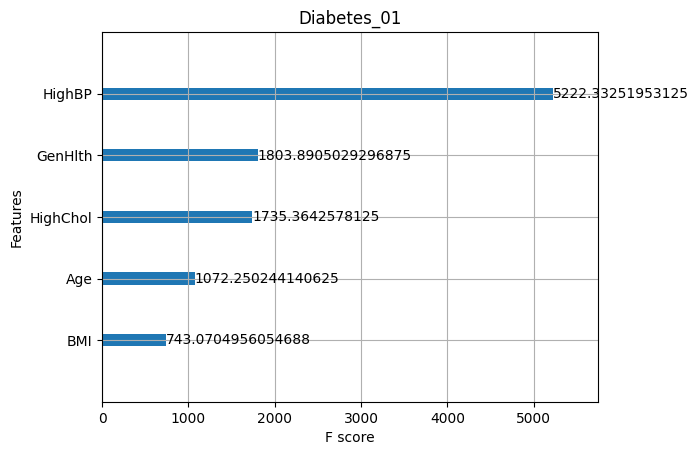

In [27]:
# Plot the top features by importance
xgb.plot_importance(model_diabetes01, importance_type='gain', title='Diabetes_01')
plt.show()

Train accuracy: 73.73%


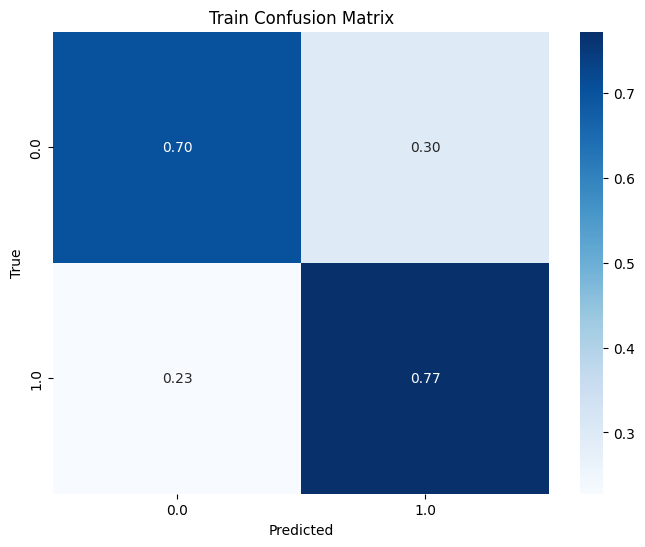

In [28]:
# Plot the confusion matrix values for the undersampled training set
confusion_plot(
    y_train_diabetes01_sm, 
    (model_diabetes01.predict(dtrain_diabetes01) >= 0.5).astype(int),
    'Train',
    list(set(y_train_diabetes01_sm)))

Valid accuracy: 70.04%


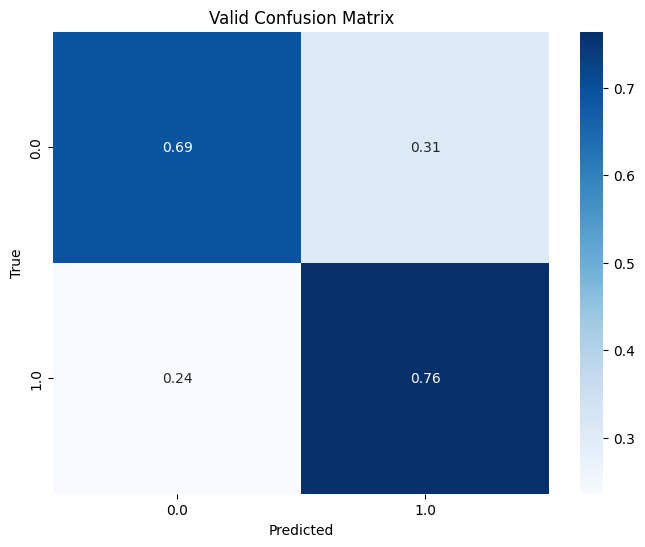

In [29]:
# Plot the confusion matrix values for the original validation set
confusion_plot(
    y_test_diabetes01, 
    preds_diabetes01,
    'Valid',
    list(set(y_test_diabetes01)))